Single LSTM

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [61]:
# Load the rainfall data
data = pd.read_csv('Data1_Columbia.csv')

In [62]:
data.head()

,Rainfall,T2M,T2MWET,T2M_MAX,T2M_MIN,T2MDEW,RH2M,WS2M_MAX,WS2M_MIN,WD10M,PS
0,8.20,26.12,24.44,26.70,25.63,22.75,81.56,4.15,0.57,56.50,101.19
1,0.72,26.96,25.01,27.42,26.15,23.05,79.19,5.38,4.21,47.94,101.17
2,5.68,26.15,23.98,26.62,25.89,21.82,77.00,2.18,0.19,158.00,101.09
3,4.25,26.02,23.74,26.38,25.80,21.47,75.94,2.73,0.68,87.69,101.16
4,8.20,26.12,24.44,26.70,25.63,22.75,81.56,4.15,0.57,56.50,101.19


In [63]:
# Extract the rainfall values
rainfall_values = data['Rainfall'].values

In [64]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_values.reshape(-1, 1))


In [65]:
# Define the sequence length and number of features
sequence_length = 13
n_features = 1

In [66]:
# Create sequences and labels
sequences = []
labels = []
for i in range(sequence_length, len(scaled_data)):
    sequences.append(scaled_data[i-sequence_length:i, 0])
    labels.append(scaled_data[i, 0])

In [67]:
# Convert sequences and labels to NumPy arrays
sequences = np.array(sequences)
labels = np.array(labels)

In [68]:
# Reshape sequences for LSTM input
sequences = np.reshape(sequences, (sequences.shape[0], sequence_length, n_features))

In [69]:
# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))

In [70]:
train_sequences = sequences[:split_index]
train_labels = labels[:split_index]
test_sequences = sequences[split_index:]
test_labels = labels[split_index:]

In [71]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)))
model.add(LSTM(50))
model.add(Dense(1))


In [72]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [73]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [74]:
# Train the model and store the training history
history = model.fit(train_sequences, train_labels, epochs=100, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])

Epoch 1/100
386/386 [==============================] - 13s 17ms/step - loss: 0.0102 - val_loss: 8.9600e-04
Epoch 2/100
386/386 [==============================] - 5s 13ms/step - loss: 3.5786e-05 - val_loss: 8.9810e-04
Epoch 3/100
386/386 [==============================] - 5s 13ms/step - loss: 3.7360e-05 - val_loss: 9.0231e-04
Epoch 4/100
386/386 [==============================] - 5s 13ms/step - loss: 3.9672e-05 - val_loss: 8.9516e-04
Epoch 5/100
386/386 [==============================] - 5s 13ms/step - loss: 3.9180e-05 - val_loss: 8.9745e-04
Epoch 6/100
386/386 [==============================] - 5s 14ms/step - loss: 3.8813e-05 - val_loss: 8.9508e-04
Epoch 7/100
386/386 [==============================] - 6s 15ms/step - loss: 4.1326e-05 - val_loss: 8.9078e-04
Epoch 8/100
386/386 [==============================] - 5s 14ms/step - loss: 3.9257e-05 - val_loss: 9.9267e-04
Epoch 9/100
386/386 [==============================] - 6s 15ms/step - loss: 4.1435e-05 - val_loss: 8.9090e-04
Epoch 10/100


In [75]:
# Make predictions
predicted_labels = model.predict(test_sequences)

97/97 [==============================] - 2s 6ms/step


In [76]:
# Inverse transform the predicted and actual labels
predicted_labels = scaler.inverse_transform(predicted_labels)
test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1))


In [77]:
# Calculate evaluation metrics
mae = np.mean(np.abs(predicted_labels - test_labels))
rmse = np.sqrt(np.mean(np.square(predicted_labels - test_labels)))
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Square Error (RMSE):', rmse)


Mean Absolute Error (MAE): 8.062530795350467
Root Mean Square Error (RMSE): 25.87358703718422


In [78]:
# Extract training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

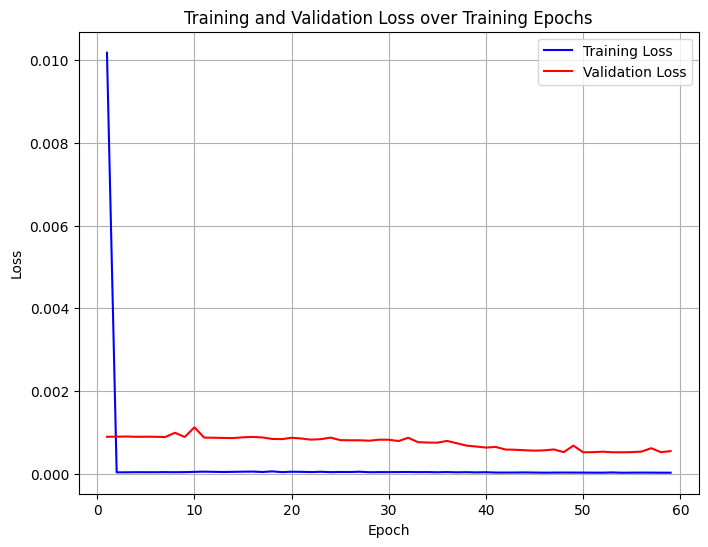

In [79]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, color='blue', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# Define the threshold for rainfall prediction
threshold = 0.5

In [81]:
# Convert predicted labels to binary values based on the threshold
binary_predicted_labels = (predicted_labels > threshold).astype(int)


In [82]:
# Calculate the percentage of rainfall predictions
prediction_percentage = np.mean(binary_predicted_labels) * 100

print("Rainfall Prediction Percentage: {:.2f}%".format(prediction_percentage))

Rainfall Prediction Percentage: 99.84%
